In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [28]:
from networks import IMVFullLSTM

In [29]:
data1 = pd.read_csv("../from_dgx/TS_datasets/sml2010/NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("../from_dgx/TS_datasets/sml2010/NEW-DATA-2.T15.txt", sep=' ')

In [30]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [6]:
data1.head()

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,95436.8,758.880,0,0,0,18.1150,48.3750,2.0,NaN,NaN
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,95436.8,762.069,0,0,0,18.4147,47.8080,2.0,NaN,NaN
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,95398.6,766.251,0,0,0,18.8533,47.4320,2.0,NaN,NaN
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,95360.3,766.037,0,0,0,19.2907,47.0240,2.0,NaN,NaN
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,95354.9,762.743,0,0,0,19.7400,45.4743,2.0,NaN,NaN


In [31]:
train_size = 3200
val_size = 400
depth = 10
batch_size = 128
prediction_horizon = 1

In [32]:
X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

In [33]:
for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

In [34]:
X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

In [35]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [36]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [37]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

In [38]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [39]:
X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

In [40]:
X_train.shape, y_train.shape

((3179, 10, 17), (3179,))

In [41]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [42]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [43]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [44]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [65]:
model = IMVFullLSTM(X_train.shape[2], 1, 128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [68]:
import time

Saving...
Iter:  0 train:  0.3297640636721517 val:  0.22929273533374217
Iter time:  1.5198963510338217
mse:  25.446377 mae:  4.341224


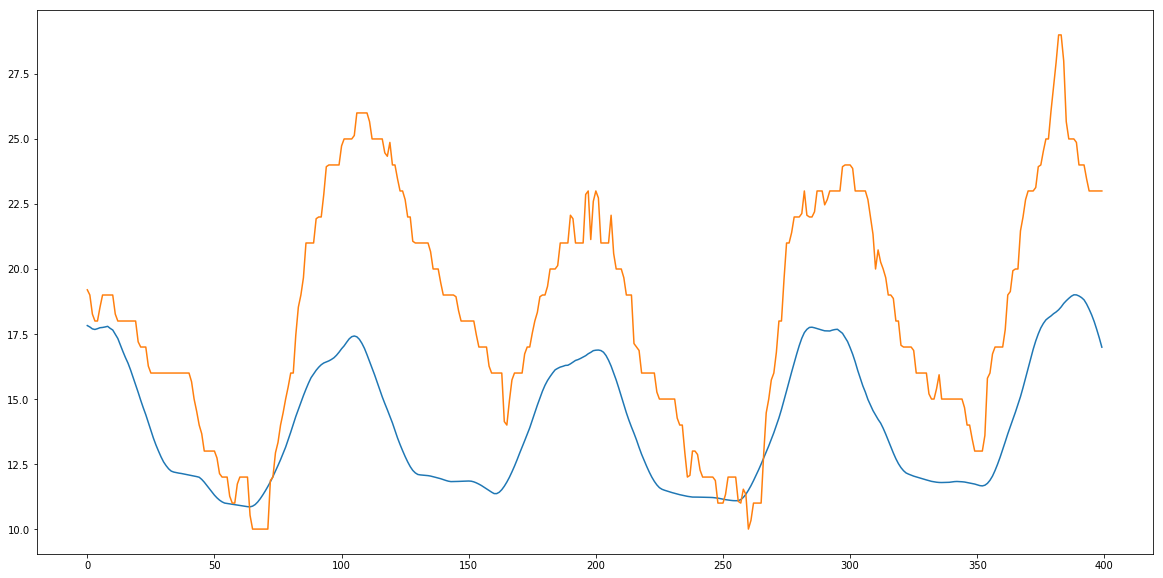

Saving...
Iter:  1 train:  0.1170404170473995 val:  0.08414865915430236
Iter time:  1.3670053340028971
Saving...
Iter:  2 train:  0.0855694156562114 val:  0.07140244931627929
Iter time:  1.3669744919752702
Saving...
Iter:  3 train:  0.0727361475557876 val:  0.06153165716939365
Iter time:  1.3976789839798585
Saving...
Iter:  4 train:  0.06419002914606631 val:  0.05548041180803331
Iter time:  1.3801894689677283
Saving...
Iter:  5 train:  0.061710068482880666 val:  0.05429317827127353
Iter time:  1.400678799021989
Saving...
Iter:  6 train:  0.05884485689697518 val:  0.053541826008740176
Iter time:  1.3789790249429643
Iter:  7 train:  0.056531838711124854 val:  0.05556984020945773
Iter time:  1.3441439450252801
Saving...
Iter:  8 train:  0.0545273879010518 val:  0.05201195616171926
Iter time:  1.373812364996411
Saving...
Iter:  9 train:  0.05236910258335984 val:  0.04871226947495925
Iter time:  1.3759364599827677
Saving...
Iter:  10 train:  0.04969732448721878 val:  0.04834208261718982
Ite

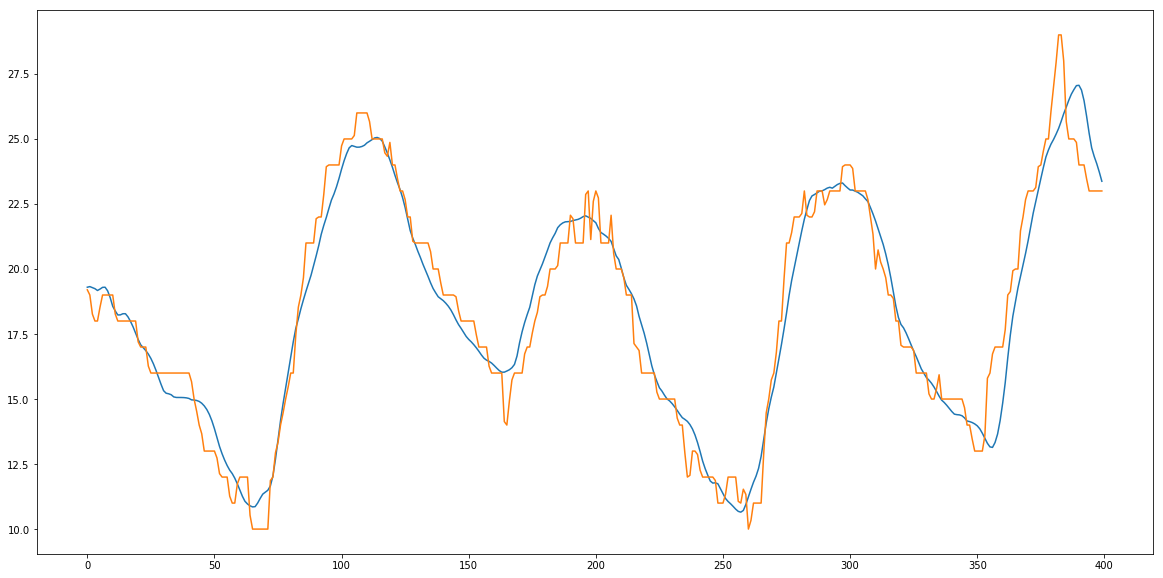

Saving...
Iter:  11 train:  0.04903230690497586 val:  0.047485081689062805
Iter time:  1.3801289410330355
Iter:  12 train:  0.047124968579899486 val:  0.05653852278931615
Iter time:  1.33046597300563
Saving...
Iter:  13 train:  0.04607875088200453 val:  0.0474094610132613
Iter time:  1.3706312089925632
Iter:  14 train:  0.04858579728657191 val:  0.05812418652229296
Iter time:  1.3276876560412347
Iter:  15 train:  0.04899089957267873 val:  0.0490774768700321
Iter time:  1.3299427119782194
Iter:  16 train:  0.04380674162786405 val:  0.04797129035647124
Iter time:  1.328244774020277
Iter:  17 train:  0.04544011546256594 val:  0.04972009655731224
Iter time:  1.329562509083189
Iter:  18 train:  0.04442353931162182 val:  0.04820810322427054
Iter time:  1.3385316219646484
Saving...
Iter:  19 train:  0.04341459116458173 val:  0.04701147834580068
Iter time:  1.4000620651058853
Iter:  20 train:  0.04217967579620606 val:  0.050558984417346554
Iter time:  1.3438664010027424
mse:  1.2372062 mae:  0

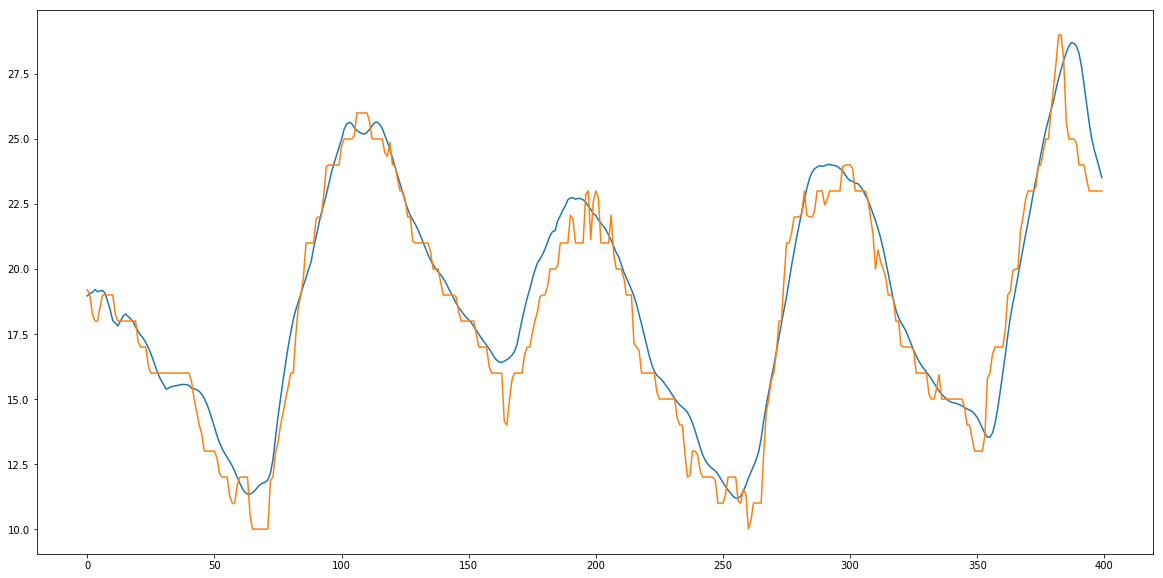

Iter:  21 train:  0.044558744394705356 val:  0.051474635805033836
Iter time:  1.3251775320386514
Saving...
Iter:  22 train:  0.041614741816358214 val:  0.045128781616572425
Iter time:  1.372897355002351
Iter:  23 train:  0.03994364141328853 val:  0.04595506786297845
Iter time:  1.3268050340702757
Saving...
Iter:  24 train:  0.03910998258007618 val:  0.0447992134574939
Iter time:  1.379452881985344
Iter:  25 train:  0.039844380935494125 val:  0.049223257040113134
Iter time:  1.3314498249674216
Iter:  26 train:  0.038503352530815854 val:  0.04663908441513607
Iter time:  1.3464707219973207
Iter:  27 train:  0.03955684113226901 val:  0.048881354500595824
Iter time:  1.3396166410529986
Iter:  28 train:  0.04013622659108545 val:  0.047949592643258966
Iter time:  1.3400866179727018
Saving...
Iter:  29 train:  0.038733924858549575 val:  0.04282574612295435
Iter time:  1.3748878060141578
Iter:  30 train:  0.040912739345676095 val:  0.04869284390906586
Iter time:  1.343902006978169
mse:  1.14756

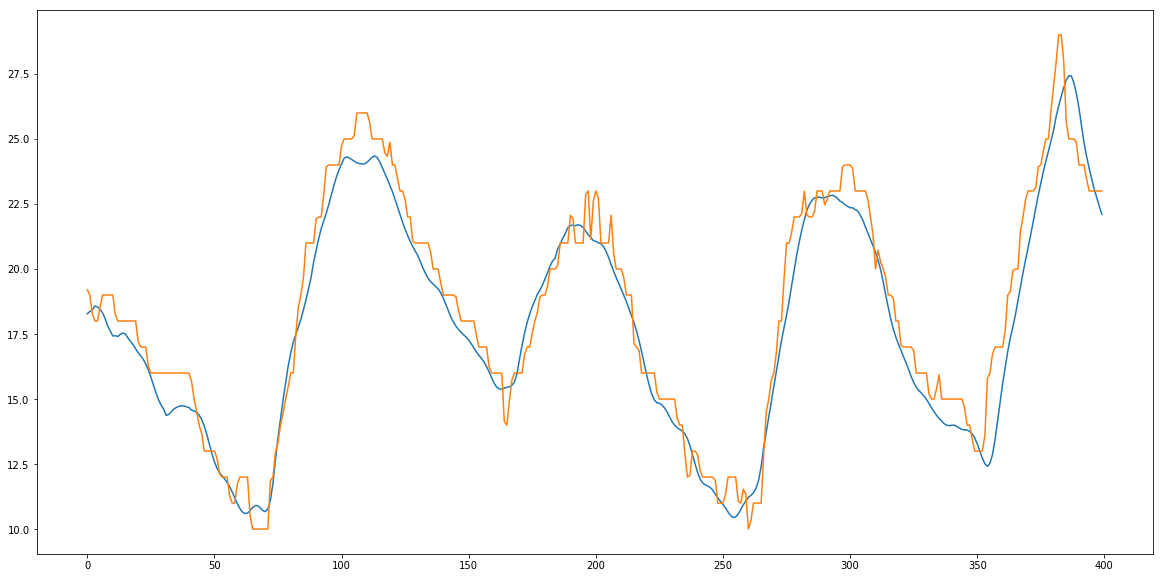

Iter:  31 train:  0.03907173506521791 val:  0.04904199416188438
Iter time:  1.3472630489850417
Iter:  32 train:  0.038008824422196455 val:  0.04469471926496321
Iter time:  1.3342895660316572
Saving...
Iter:  33 train:  0.03608655372203021 val:  0.04186471798620363
Iter time:  1.3746741999639198
Iter:  34 train:  0.03373924602361735 val:  0.042619623294665405
Iter time:  1.3297075639711693
Iter:  35 train:  0.035746881936138175 val:  0.04390338890079999
Iter time:  1.3300183549290523
Saving...
Iter:  36 train:  0.03529053079234945 val:  0.04117425940628698
Iter time:  1.3766181950923055
Iter:  37 train:  0.038732899460123094 val:  0.05178277403431013
Iter time:  1.3306864849291742
Iter:  38 train:  0.036382042292514 val:  0.04136095268373455
Iter time:  1.3312151690479368
Saving...
Iter:  39 train:  0.03268445875627072 val:  0.04090834666081479
Iter time:  1.39378897997085
Iter:  40 train:  0.03453962253095759 val:  0.04293179830511171
Iter time:  1.3446162129985169
mse:  0.8920795 mae:

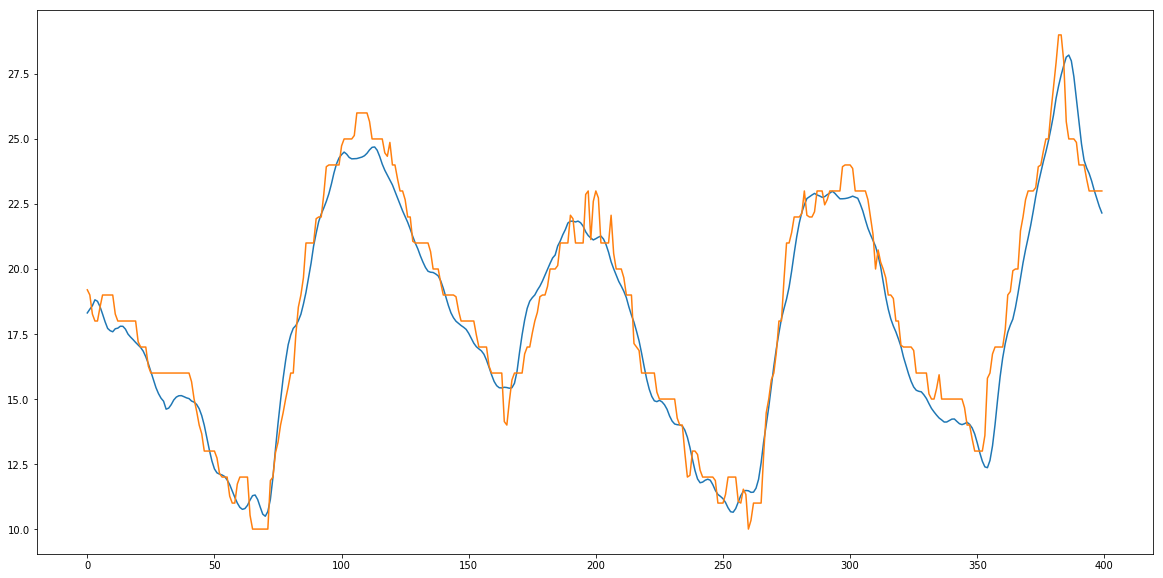

Iter:  41 train:  0.03883879026925495 val:  0.04126581181574534
Iter time:  1.3336296170018613
Iter:  42 train:  0.03413170740148669 val:  0.04606456014181213
Iter time:  1.351748252985999
Saving...
Iter:  43 train:  0.034406283085277906 val:  0.04065716964464439
Iter time:  1.4166300479555503
Iter:  44 train:  0.03263866095830697 val:  0.041697146969502705
Iter time:  1.3490512348944321
Iter:  45 train:  0.031291391086961697 val:  0.045546502337558824
Iter time:  1.3451967550208792
Iter:  46 train:  0.03188849290680688 val:  0.044885634855635834
Iter time:  1.3526458110427484
Iter:  47 train:  0.032067730583438675 val:  0.043639201761113876
Iter time:  1.3483410249464214
Saving...
Iter:  48 train:  0.03324732220030012 val:  0.03887763649695144
Iter time:  1.386414077016525
Iter:  49 train:  0.030667909049183272 val:  0.0393696813737852
Iter time:  1.3472188710002229
Iter:  50 train:  0.030382293439819356 val:  0.04055829348595828
Iter time:  1.3484883318888023
mse:  0.7961681 mae:  0.

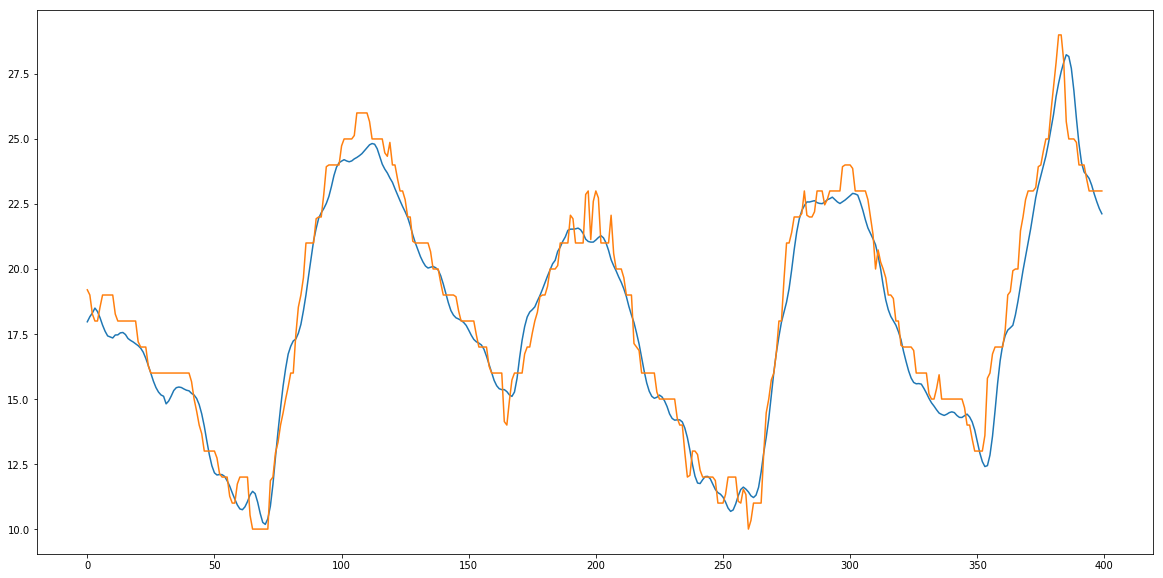

Iter:  51 train:  0.03276598797066962 val:  0.039432627716626104
Iter time:  1.3533463008934632
Iter:  52 train:  0.030818300901926096 val:  0.04013353947765765
Iter time:  1.3372931579360738
Iter:  53 train:  0.029374537583475923 val:  0.039335524330507354
Iter time:  1.3411386479856446
Saving...
Iter:  54 train:  0.029464823753198807 val:  0.03795689742698842
Iter time:  1.3805414660600945
Iter:  55 train:  0.028371502354359895 val:  0.0422601188512325
Iter time:  1.33354229608085
Saving...
Iter:  56 train:  0.02957732428536957 val:  0.03790277969430452
Iter time:  1.3734340770170093
Iter:  57 train:  0.03200528791939687 val:  0.04457929042274845
Iter time:  1.3387080379761755
Iter:  58 train:  0.03444252711604404 val:  0.04915442312438639
Iter time:  1.343586268951185
Iter:  59 train:  0.03258022895106513 val:  0.03908424630434048
Iter time:  1.3552775100106373
Iter:  60 train:  0.02889274271742553 val:  0.038301277882042115
Iter time:  1.3444357209373266
mse:  0.71002215 mae:  0.64

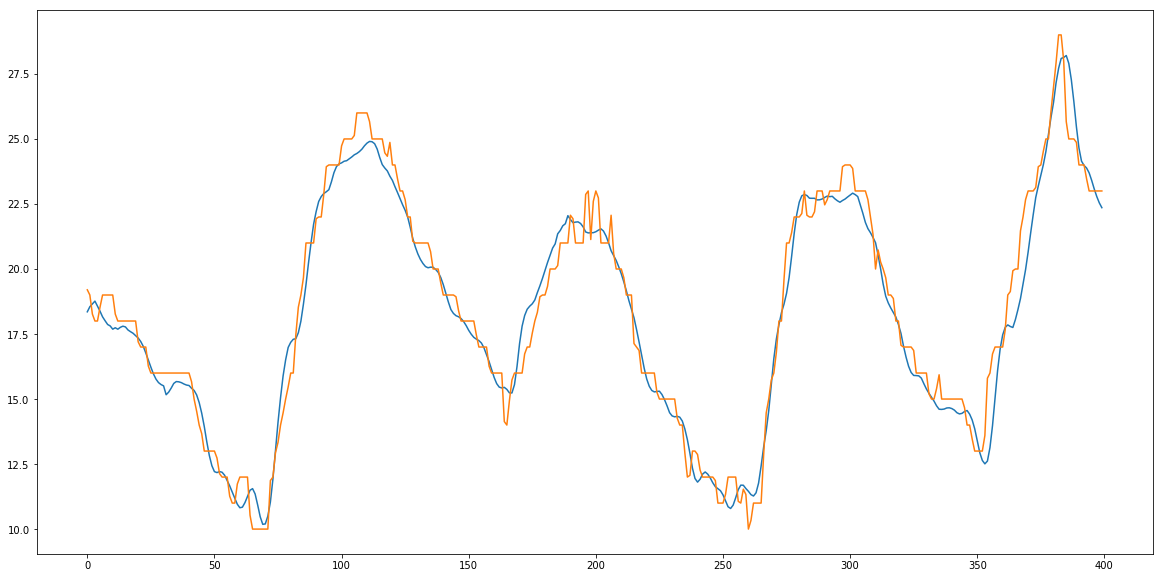

Saving...
Iter:  61 train:  0.027619591876931252 val:  0.03695979955792551
Iter time:  1.402180755045265
Iter:  62 train:  0.0282963727434128 val:  0.04278452089496714
Iter time:  1.3307548658922315
Iter:  63 train:  0.027344371828638022 val:  0.0375758934201027
Iter time:  1.3306597030023113
Iter:  64 train:  0.02710686921310315 val:  0.03917954195742896
Iter time:  1.3302603259216994
Saving...
Iter:  65 train:  0.02644053180663016 val:  0.03681850768853637
Iter time:  1.3781801690347493
Saving...
Iter:  66 train:  0.029751503079714296 val:  0.03614763072024352
Iter time:  1.3877040760125965
Iter:  67 train:  0.02864882547037791 val:  0.04380168862926653
Iter time:  1.3374629740137607
Iter:  68 train:  0.027473061151681966 val:  0.03680960772045915
Iter time:  1.3357575460104272
Iter:  69 train:  0.026635107782699126 val:  0.03750281348204367
Iter time:  1.3316270139766857
Saving...
Iter:  70 train:  0.027850073074794514 val:  0.035615129232709035
Iter time:  1.3830998099874705
mse:  

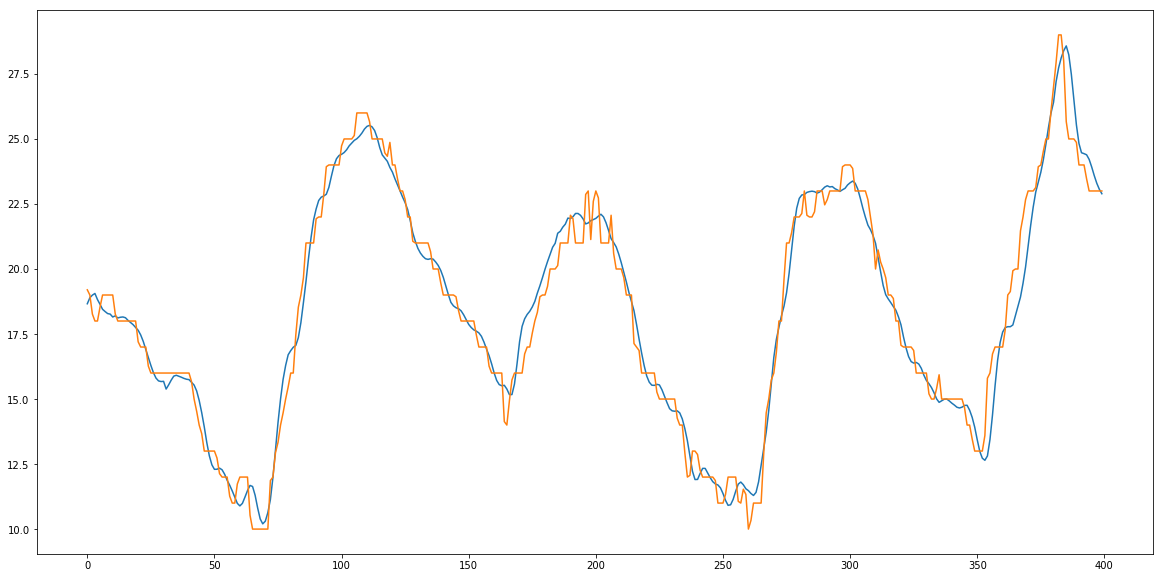

Iter:  71 train:  0.02652652679703257 val:  0.03664009084698539
Iter time:  1.3451470279833302
Iter:  72 train:  0.026308122696243892 val:  0.03626260488969005
Iter time:  1.3473785129608586
Iter:  73 train:  0.02596581914161525 val:  0.041036983106165714
Iter time:  1.3469140189699829
Iter:  74 train:  0.02739908682996007 val:  0.042381980993314944
Iter time:  1.3377112259622663
Iter:  75 train:  0.027343097880098474 val:  0.03727303955003213
Iter time:  1.3448980269022286
Iter:  76 train:  0.028115698621957435 val:  0.03776255993405839
Iter time:  1.3455285710515454
Saving...
Iter:  77 train:  0.026866031619925523 val:  0.0355970657150629
Iter time:  1.392466222983785
Iter:  78 train:  0.02585677458486128 val:  0.03842510919680278
Iter time:  1.3396578340325505
Iter:  79 train:  0.02539872598322001 val:  0.03582563729369054
Iter time:  1.345328358002007
Saving...
Iter:  80 train:  0.025338391548152105 val:  0.035254575136554514
Iter time:  1.3829930910142139
mse:  0.6015563 mae:  0.5

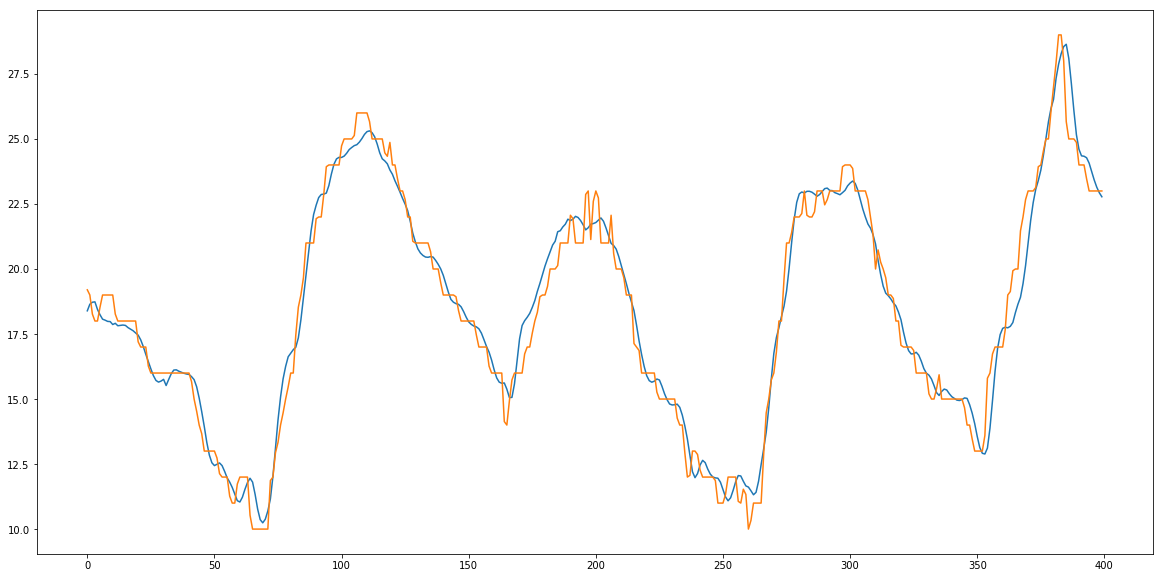

Iter:  81 train:  0.025238573151519242 val:  0.03544207585043951
Iter time:  1.3478074580198154
Iter:  82 train:  0.02444661502887892 val:  0.03605381823552983
Iter time:  1.3536114760208875
Iter:  83 train:  0.025509242028243576 val:  0.03617849477870746
Iter time:  1.3464512870414183
Iter:  84 train:  0.027254182348375126 val:  0.03645890292222273
Iter time:  1.3478661760454997
Iter:  85 train:  0.025045807083402486 val:  0.03709586380639709
Iter time:  1.3611992680234835
Iter:  86 train:  0.026715899917675826 val:  0.038251196488821415
Iter time:  1.3439737879671156
Saving...
Iter:  87 train:  0.026146481388332882 val:  0.034956736285569806
Iter time:  1.3831936579663306
Saving...
Iter:  88 train:  0.02596196731076535 val:  0.034739307557841076
Iter time:  1.3826266539981589
Iter:  89 train:  0.025155110379544796 val:  0.044602193757519754
Iter time:  1.3527815400157124
Iter:  90 train:  0.026505562159862227 val:  0.03524202320886776
Iter time:  1.3489509229548275
mse:  0.6011281 ma

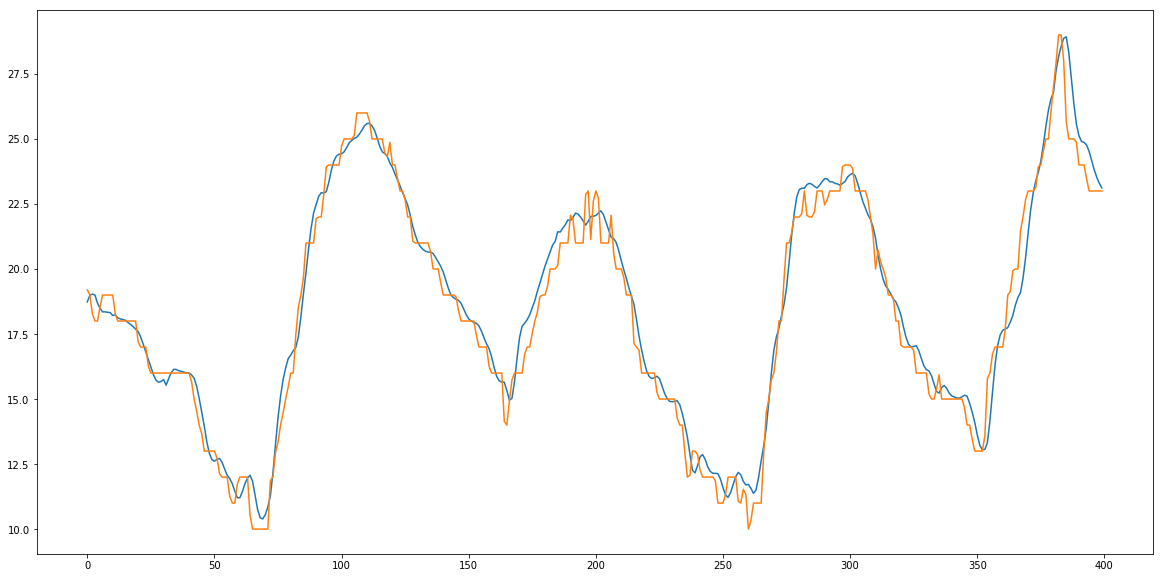

Iter:  91 train:  0.024401012696287666 val:  0.035347578314202995
Iter time:  1.3463735810946673
Iter:  92 train:  0.023557711019191463 val:  0.03516134834408903
Iter time:  1.3349019510205835
Saving...
Iter:  93 train:  0.0248263219502612 val:  0.03387056922308485
Iter time:  1.395863667014055
Iter:  94 train:  0.023856400534939 val:  0.035249666106937284
Iter time:  1.3425022230949253
Iter:  95 train:  0.02572744021217438 val:  0.03460570560274798
Iter time:  1.3349755799863487
Iter:  96 train:  0.026303295484581938 val:  0.03710728833957428
Iter time:  1.3470243719639257
Iter:  97 train:  0.02342853345946118 val:  0.03502733157015066
Iter time:  1.3386483499780297
Iter:  98 train:  0.0233717155401067 val:  0.03400661354746992
Iter time:  1.343704883940518
Saving...
Iter:  99 train:  0.024426656528166737 val:  0.03233528984842418
Iter time:  1.4115022328915074
Iter:  100 train:  0.023332150225281154 val:  0.03468665223975848
Iter time:  1.3525168809574097
mse:  0.5823313 mae:  0.5815

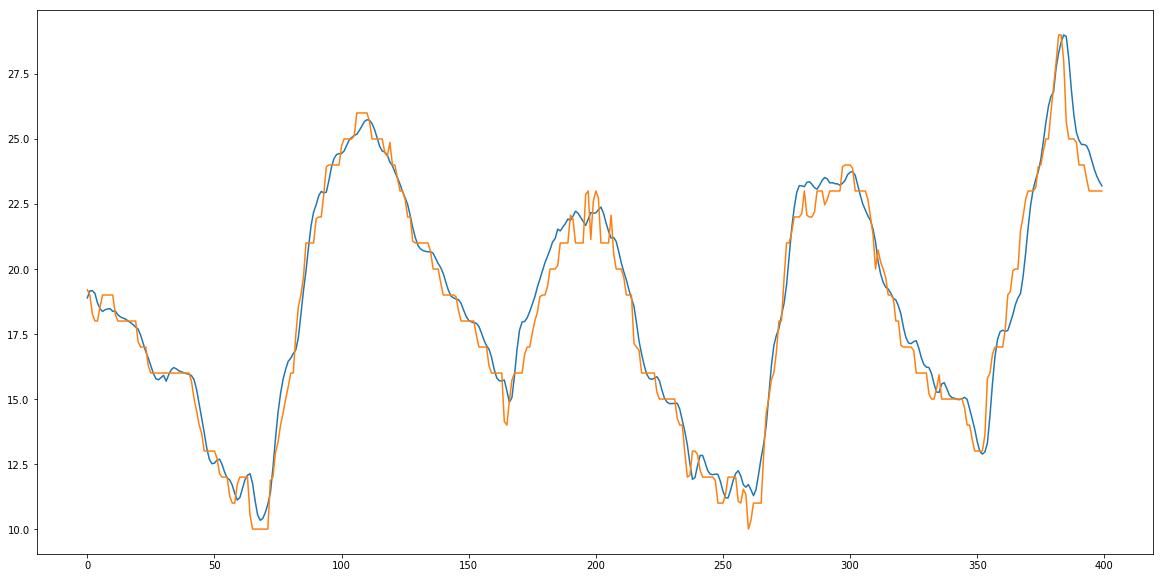

Iter:  101 train:  0.023810238212143085 val:  0.033192016482369434
Iter time:  1.3527867229422554
Iter:  102 train:  0.02231269843368272 val:  0.03494604502122732
Iter time:  1.3421854289481416
Iter:  103 train:  0.02277478399438201 val:  0.033499981345965046
Iter time:  1.3441730820341036
Iter:  104 train:  0.022955973747438994 val:  0.0330924234878607
Iter time:  1.3574782939394936
Saving...
Iter:  105 train:  0.023184867659126862 val:  0.03189944240557715
Iter time:  1.3950485730310902
Iter:  106 train:  0.022196203746680614 val:  0.03425286171349696
Iter time:  1.332545695011504
Iter:  107 train:  0.022853018860619308 val:  0.03411828779595643
Iter time:  1.3418837280478328
Iter:  108 train:  0.022136901630126656 val:  0.03626798636998485
Iter time:  1.3462054909905419
Iter:  109 train:  0.022989872856877844 val:  0.032045937142442485
Iter time:  1.3501749290153384
Iter:  110 train:  0.02161402804547721 val:  0.0332267471039714
Iter time:  1.349621913046576
mse:  0.53434396 mae:  0

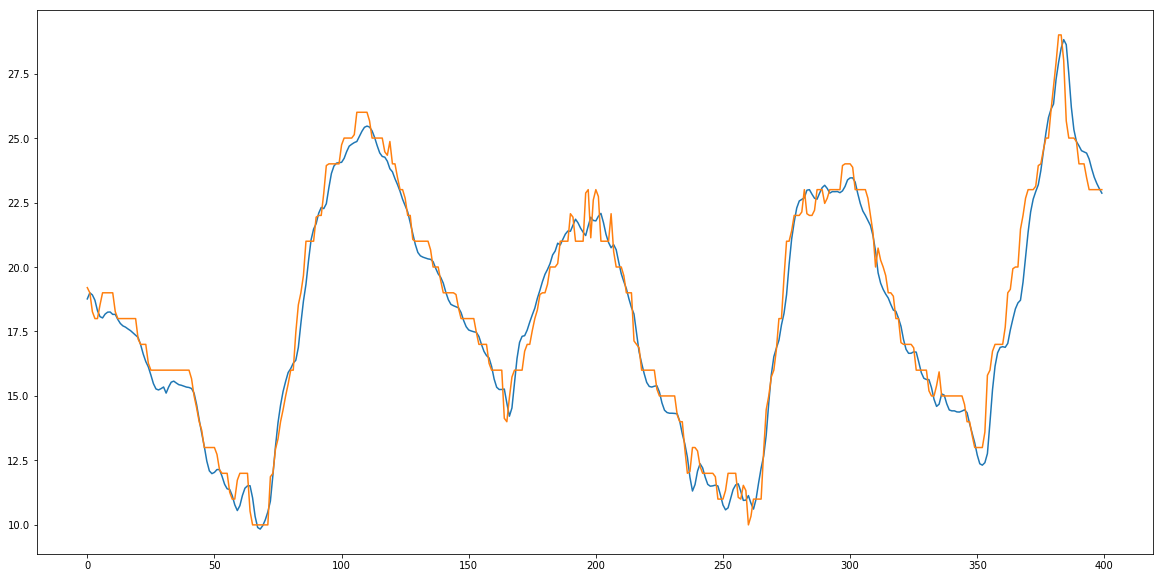

Iter:  111 train:  0.02236451635555777 val:  0.033310122592072576
Iter time:  1.342220108024776
Iter:  112 train:  0.021397943561902333 val:  0.03670729093103561
Iter time:  1.3313687869813293
Saving...
Iter:  113 train:  0.022594200293092625 val:  0.0315125503257715
Iter time:  1.4127835260005668
Saving...
Iter:  114 train:  0.02211897010014371 val:  0.030471859216994055
Iter time:  1.3875343019608408
Iter:  115 train:  0.02290273173509637 val:  0.033712611090578194
Iter time:  1.3355389500502497
Iter:  116 train:  0.021867220933768604 val:  0.03369942887473844
Iter time:  1.3404881319729611
Iter:  117 train:  0.0216143269147929 val:  0.031896627535962105
Iter time:  1.3399747009389102
Iter:  118 train:  0.021179189435509775 val:  0.0313756669057205
Iter time:  1.335421958938241
Iter:  119 train:  0.022166989144285373 val:  0.03055578327530598
Iter time:  1.3443298490019515
Iter:  120 train:  0.021679208613925305 val:  0.03186859491919883
Iter time:  1.33572557894513
mse:  0.4915539 m

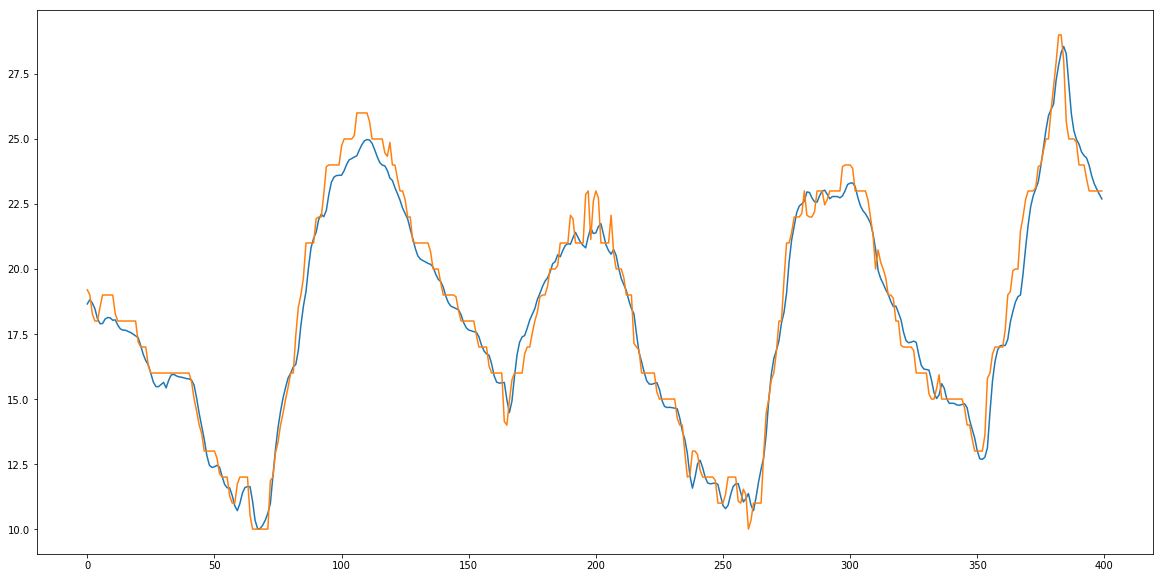

Iter:  121 train:  0.021501049138636638 val:  0.031565686067443366
Iter time:  1.3443732989253476
Iter:  122 train:  0.02080313722770975 val:  0.03292473291929259
Iter time:  1.355870058061555
Iter:  123 train:  0.021285059952364658 val:  0.030594710264828972
Iter time:  1.3585606769192964
Iter:  124 train:  0.022361930401928305 val:  0.03142433621941041
Iter time:  1.3490016700234264
Iter:  125 train:  0.023113228881968484 val:  0.03179391196337893
Iter time:  1.338084968039766
Iter:  126 train:  0.021816674044254702 val:  0.03201439402342185
Iter time:  1.347544674994424
Iter:  127 train:  0.020931635114769004 val:  0.03132434599218226
Iter time:  1.3469382229959592
Iter:  128 train:  0.0200951982493418 val:  0.031066729352170933
Iter time:  1.3432871939148754
Saving...
Iter:  129 train:  0.01984802892670764 val:  0.02988017653389384
Iter time:  1.3871870370348915
Iter:  130 train:  0.021837593523658497 val:  0.03212998107225434
Iter time:  1.3695568420225754
mse:  0.4996504 mae:  0.

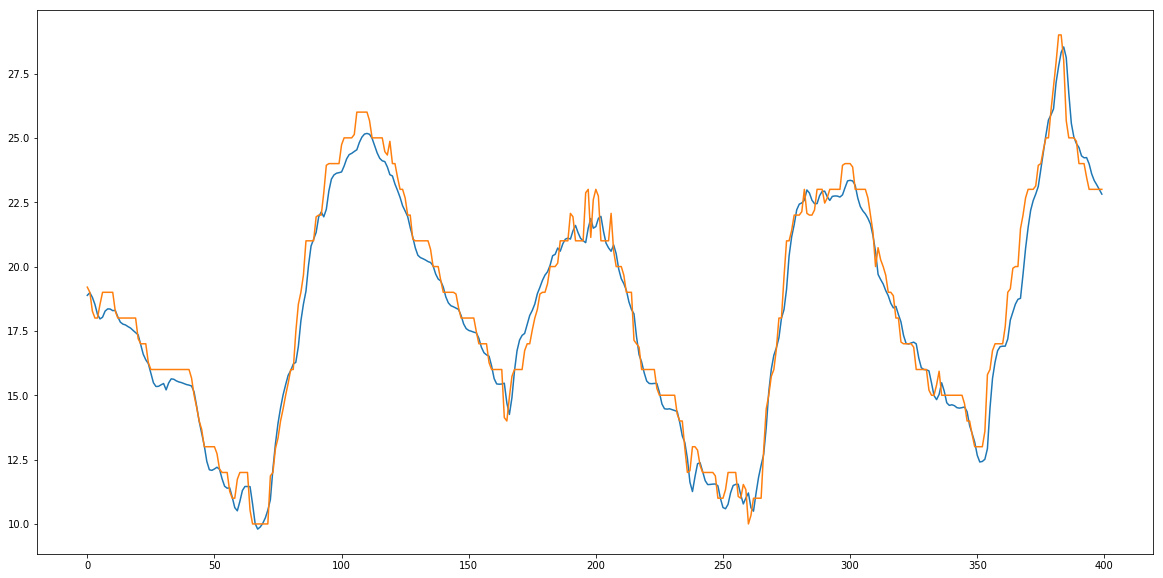

Iter:  131 train:  0.020341580979075836 val:  0.03175964692695741
Iter time:  1.3606748740421608
Iter:  132 train:  0.022489137460070918 val:  0.030824832959449565
Iter time:  1.356905758031644
Iter:  133 train:  0.021724270958412752 val:  0.030053263458713637
Iter time:  1.3432072749128565
Iter:  134 train:  0.019728067723534005 val:  0.03041197518388971
Iter time:  1.3389242090051994
Iter:  135 train:  0.021293299832451186 val:  0.031154077655048937
Iter time:  1.343127548112534
Iter:  136 train:  0.02091543466725522 val:  0.030327376796419725
Iter time:  1.3401620120275766
Saving...
Iter:  137 train:  0.019677336426873106 val:  0.02945555170393196
Iter time:  1.4135571320075542
Iter:  138 train:  0.020556535735585697 val:  0.029588515028376117
Iter time:  1.3518462299834937
Saving...
Iter:  139 train:  0.01956351059650669 val:  0.02927929811908342
Iter time:  1.4328802910167724
Saving...
Iter:  140 train:  0.01945719095977409 val:  0.029175306818643217
Iter time:  1.4069837380666286

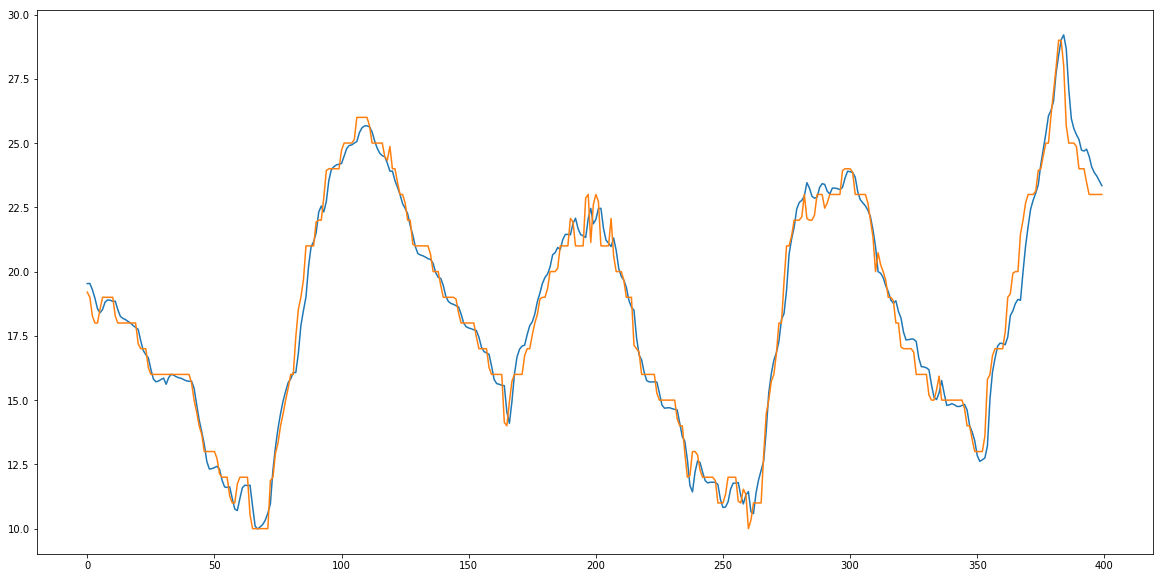

Iter:  141 train:  0.02045671519858459 val:  0.02961552201329932
Iter time:  1.3451840589987114
Iter:  142 train:  0.020120743975780925 val:  0.031048065655151676
Iter time:  1.3420582570834085
Iter:  143 train:  0.02039713255189056 val:  0.030254989663728946
Iter time:  1.3481703280704096
Iter:  144 train:  0.01943744122820074 val:  0.029579161613726066
Iter time:  1.3462404820602387
Iter:  145 train:  0.02038077426564529 val:  0.029224285159880837
Iter time:  1.3482688940130174
Iter:  146 train:  0.019558881129326376 val:  0.02961765090612048
Iter time:  1.3386978829512373
Iter:  147 train:  0.019768637714255854 val:  0.029884364829539867
Iter time:  1.3488056710921228
Iter:  148 train:  0.021262456571051094 val:  0.031241791958509756
Iter time:  1.3361751399934292
Iter:  149 train:  0.01901957254273755 val:  0.02937290023086299
Iter time:  1.3490898370509967
Iter:  150 train:  0.019655358628610405 val:  0.029957142960134558
Iter time:  1.3465055709239095
mse:  0.4343563 mae:  0.4909

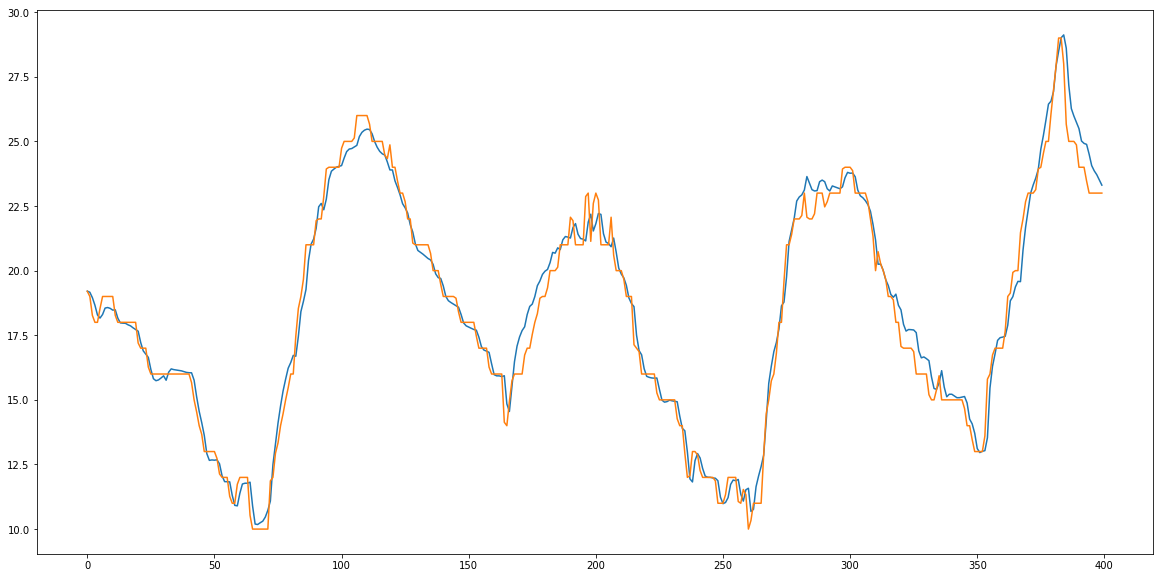

Iter:  151 train:  0.02119247278709006 val:  0.03162836158008326
Iter time:  1.346000483026728
Iter:  152 train:  0.019145768359546893 val:  0.030053726741684356
Iter time:  1.3424692320404574
Iter:  153 train:  0.01993229149123338 val:  0.03073687837167203
Iter time:  1.3332528489409015
Iter:  154 train:  0.019112683276475386 val:  0.029262322395299845
Iter time:  1.3506609960459173
Saving...
Iter:  155 train:  0.01827325977143823 val:  0.02837291108122087
Iter time:  1.4016297849593684
Iter:  156 train:  0.01883243765512569 val:  0.02881106026645714
Iter time:  1.345520943053998
Iter:  157 train:  0.01847888832862783 val:  0.028685718930914716
Iter time:  1.3484678330132738
Iter:  158 train:  0.020145022743664434 val:  0.03012771064510759
Iter time:  1.3446695260936394
Iter:  159 train:  0.018175520520437957 val:  0.029463882789937685
Iter time:  1.3441324989544228
Iter:  160 train:  0.018709744947446445 val:  0.03204198910211885
Iter time:  1.3393758700694889
mse:  0.4969175 mae:  0

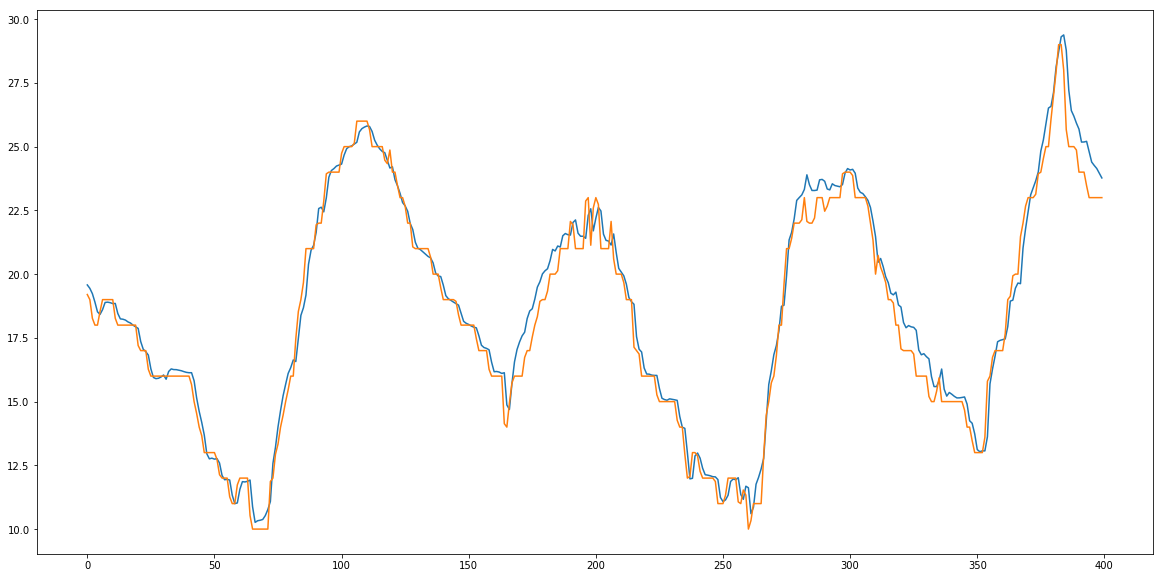

Iter:  161 train:  0.018203201364649372 val:  0.02878716706489442
Iter time:  1.3412008120212704
Iter:  162 train:  0.01773874305383559 val:  0.029417622168452937
Iter time:  1.3413086609216407
Iter:  163 train:  0.01865406153146261 val:  0.028969186816065074
Iter time:  1.3600853650132194
Iter:  164 train:  0.018326823194920717 val:  0.02893774211588639
Iter time:  1.3464640559395775
Iter:  165 train:  0.018438548203011385 val:  0.028560031320389603
Iter time:  1.3665245809825137
Iter:  166 train:  0.018586176024149977 val:  0.029956665903336517
Iter time:  1.361902054050006
Saving...
Iter:  167 train:  0.0178065085184776 val:  0.028212946406144575
Iter time:  1.4015918709337711
Iter:  168 train:  0.017545129717499254 val:  0.028726955084858296
Iter time:  1.3404461140744388
Iter:  169 train:  0.017770254273289182 val:  0.029325659439685955
Iter time:  1.3389099850319326
Saving...
Iter:  170 train:  0.01756661756894783 val:  0.0281859598204216
Iter time:  1.406699664075859
mse:  0.384

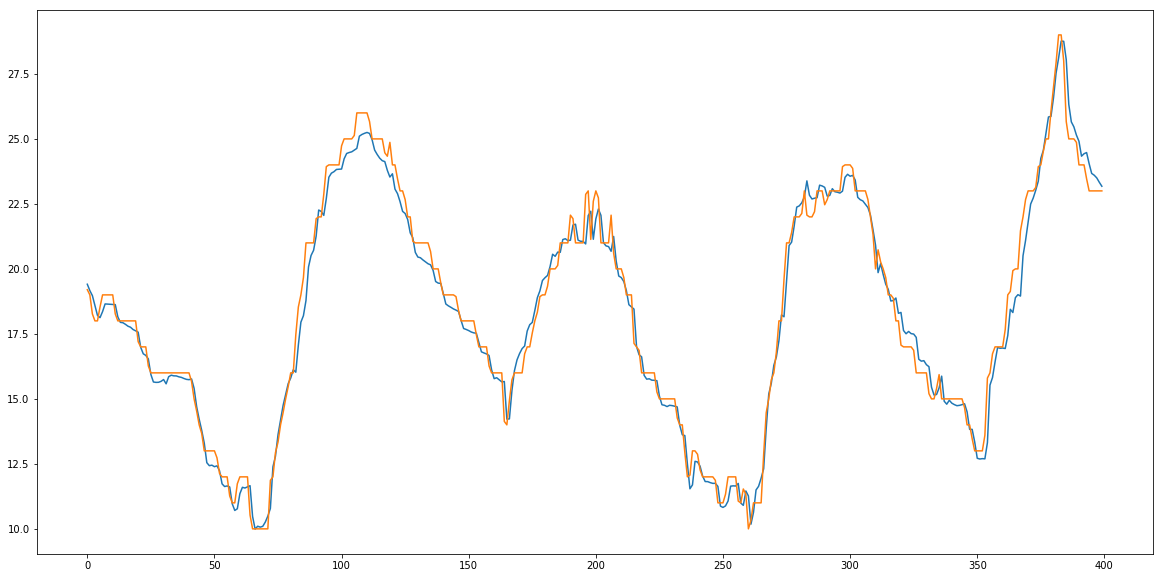

Iter:  171 train:  0.01778996753995134 val:  0.029456418179631478
Iter time:  1.3296573139959946
Iter:  172 train:  0.017518350913958345 val:  0.02856708726393285
Iter time:  1.330518446979113
Iter:  173 train:  0.01843955205625358 val:  0.029385911907126687
Iter time:  1.330569992074743
Iter:  174 train:  0.01854853635886399 val:  0.02858078090544285
Iter time:  1.3801092860521749
Iter:  175 train:  0.01818919721061055 val:  0.028733688863846137
Iter time:  1.3397059950511903
Iter:  176 train:  0.017744434059038378 val:  0.02850381315884491
Iter time:  1.3415255590807647
Iter:  177 train:  0.018256124461371898 val:  0.028595961123060107
Iter time:  1.3461196549469605
Iter:  178 train:  0.01814518282847749 val:  0.029419984759570163
Iter time:  1.3600652699824423
Iter:  179 train:  0.017613072709661795 val:  0.02957186058028562
Iter time:  1.3556762429652736
Iter:  180 train:  0.01760333772821515 val:  0.029013732889548453
Iter time:  1.3397298030322418
mse:  0.40742967 mae:  0.4670251

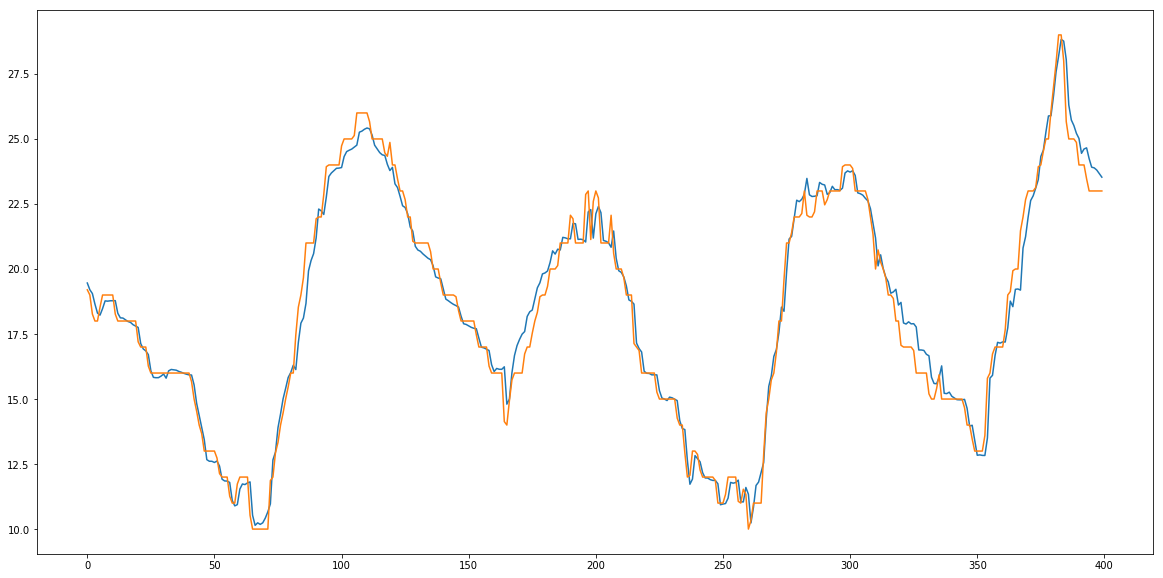

Iter:  181 train:  0.017239106721971924 val:  0.028290898405443875
Iter time:  1.3331440809415653
Iter:  182 train:  0.01753208990915058 val:  0.028602239607001704
Iter time:  1.344466674956493
Iter:  183 train:  0.017226064167976188 val:  0.028486041177763193
Iter time:  1.348088713013567
Iter:  184 train:  0.01683371126079694 val:  0.028494519594833505
Iter time:  1.3528547500027344
Iter:  185 train:  0.017319816525984584 val:  0.030992846123515116
Iter time:  1.3593145000049844
Iter:  186 train:  0.017377108993476477 val:  0.02860832562024703
Iter time:  1.3556417409563437
Iter:  187 train:  0.017000760395603394 val:  0.029720931303034936
Iter time:  1.3403080980060622
Iter:  188 train:  0.01703968061250559 val:  0.029064948936310824
Iter time:  1.3490617530187592
Iter:  189 train:  0.018472768709415856 val:  0.033538261041011125
Iter time:  1.3525114259682596
Iter:  190 train:  0.01771286181413613 val:  0.028801680802282514
Iter time:  1.3530430800747126
mse:  0.4014958 mae:  0.470

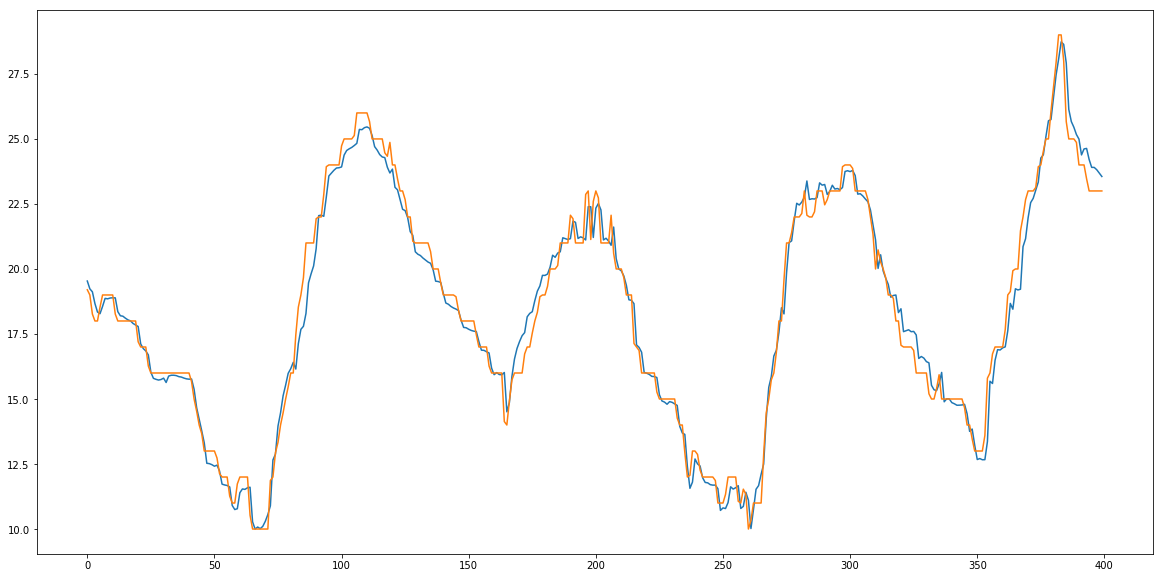

Iter:  191 train:  0.017225842203677132 val:  0.03270705286888867
Iter time:  1.3395376099506393
Iter:  192 train:  0.01736673341563871 val:  0.029580020218115895
Iter time:  1.341791148064658
Iter:  193 train:  0.01729621285158916 val:  0.02931918240680958
Iter time:  1.3365251889918
Iter:  194 train:  0.017241560576417004 val:  0.028551864621475107
Iter time:  1.3335607229964808
Iter:  195 train:  0.016895653527591255 val:  0.02903175943213049
Iter time:  1.3393747879890725
Iter:  196 train:  0.016845007270672143 val:  0.031241591037437563
Iter time:  1.3348546120105311
Iter:  197 train:  0.01722257724320532 val:  0.031240275926434143
Iter time:  1.346722738002427
Iter:  198 train:  0.01701684246859661 val:  0.030370710437968417
Iter time:  1.3446318850619718
Iter:  199 train:  0.016639540340588187 val:  0.02964157894652582
Iter time:  1.3354242789791897
Iter:  200 train:  0.016484435980277073 val:  0.02818644536951917
Iter time:  1.335295854951255
mse:  0.38452613 mae:  0.45827594


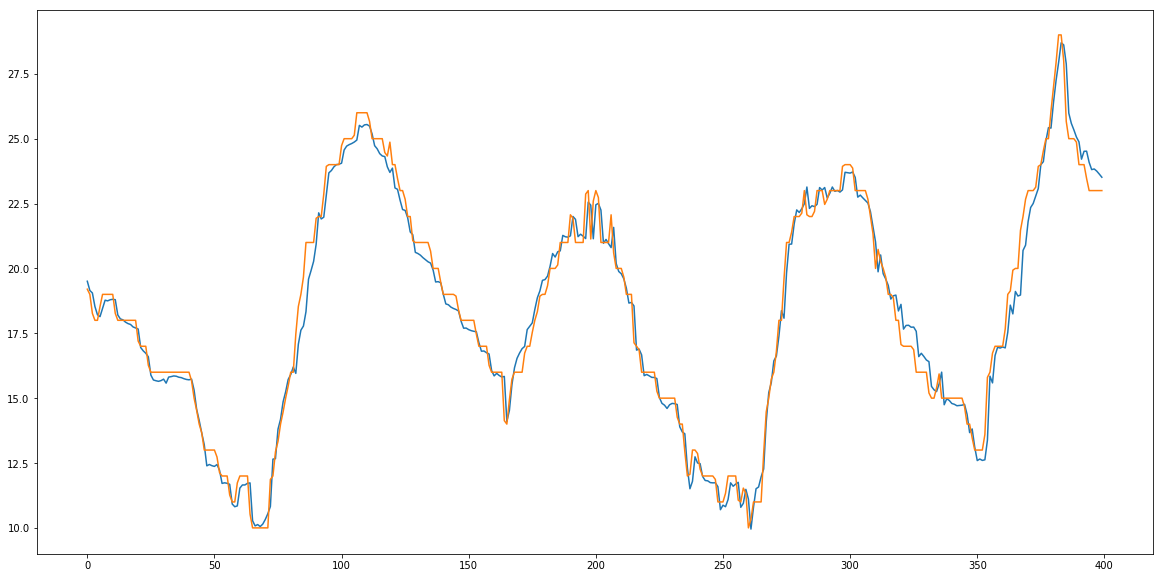

Iter:  201 train:  0.01708921941415951 val:  0.029499577392212047
Iter time:  1.33909163903445
Iter:  202 train:  0.016421131642292332 val:  0.02866172010427105
Iter time:  1.3474513730034232
Iter:  203 train:  0.016621260614504883 val:  0.028733778240397044
Iter time:  1.347605564049445
Iter:  204 train:  0.016666587465068987 val:  0.0301161562771519
Iter time:  1.3460904769599438


In [69]:
epochs = 1000
loss = nn.MSELoss()
patience = 35
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred, alphas, betas = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "imv_lstm_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [50]:
model.load_state_dict(torch.load("imv_lstm_sml2010.pt"))

<All keys matched successfully>

In [51]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        alphas.append(a.detach().cpu().numpy())
        betas.append(b.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)
alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

In [52]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [53]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [54]:
mse, mae

(0.29738528, 0.43004093)

In [55]:
mse**0.5

0.5453304276894166

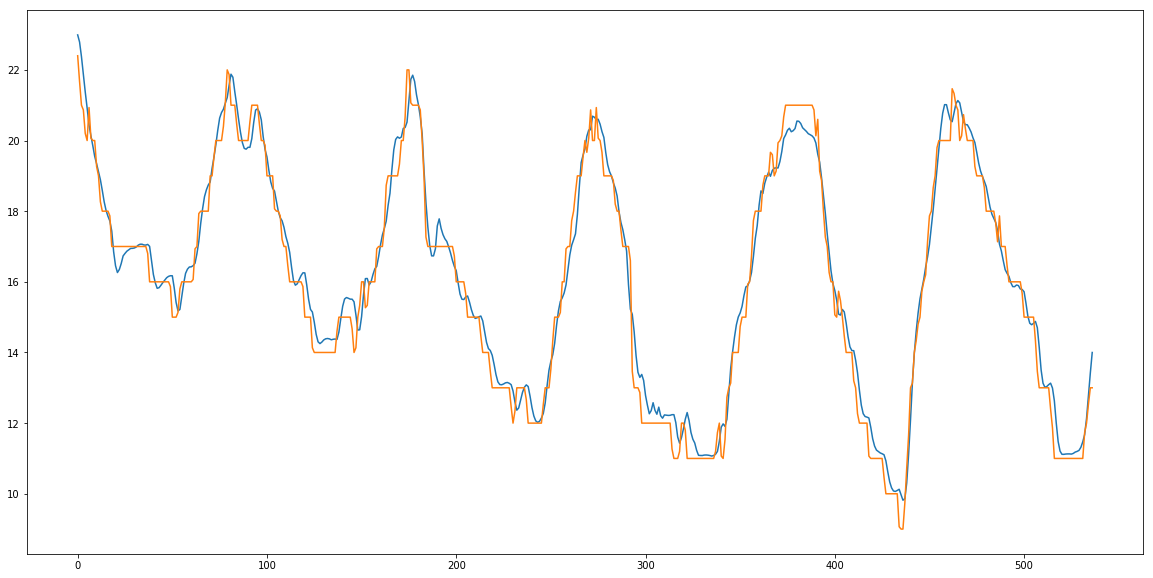

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [57]:
alphas.shape

(537, 10, 17, 1)

In [58]:
betas.shape

(537, 17, 1)

In [59]:
alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

In [60]:
alphas = alphas[..., 0]
betas = betas[..., 0]

In [61]:
alphas = alphas.transpose(1, 0)

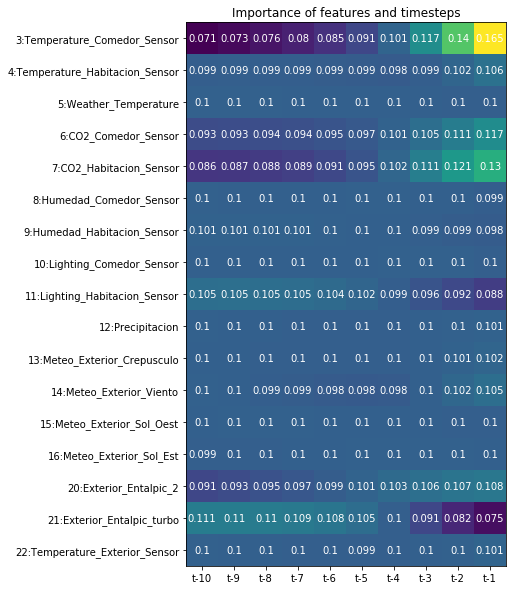

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(alphas)
ax.set_xticks(np.arange(X_train_t.shape[1]))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], -1, -1)])
ax.set_yticklabels(cols)
for i in range(len(cols)):
    for j in range(X_train_t.shape[1]):
        text = ax.text(j, i, round(alphas[i, j], 3),
                       ha="center", va="center", color="w")
ax.set_title("Importance of features and timesteps")
#fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7fc1f46534e0>,
 <a list of 17 Text xticklabel objects>)

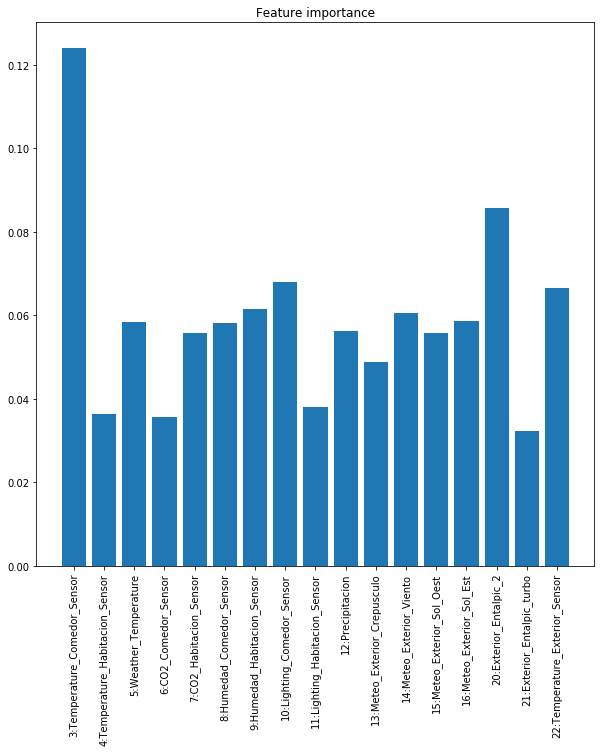

In [64]:
plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.bar(range(len(cols)), betas)
plt.xticks(range(len(cols)), cols, rotation=90)